# 0. Package

In [3]:
!pip install nnAudio
!pip install efficientnet

     |████████████████████████████████| 43 kB 526 kB/s            
     |████████████████████████████████| 50 kB 745 kB/s            


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import torch
import math
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Sequential, utils, optimizers, metrics
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
from random import shuffle
from nnAudio.Spectrogram import CQT1992v2
from scipy import signal, fft
from efficientnet.tfkeras import EfficientNetB0, EfficientNetB1
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter

TOP_INPUT_DIRECTORY = "../input/g2net-gravitational-wave-detection"
BATCH_SIZE = 256
EPOCHS = 1
EXAMPLE_IDENTIFIER_1 = "00000e74ad"
EXAMPLE_IDENTIFIER_0 = "00001f4945"
RANDOM_SAMPLE_SIZE = 1
PERFORM_FITTING = True
SAMPLING_FREQUENCY = 2048
SAMPLES_1 = 4096
SAMPLES_3 = 3 * SAMPLES_1
USE_TRAIN_SUBSET = False
USE_TEST_SUBSET = False
SUBSET_SIZE = 1024
LEARNING_RATE = 0.001
TRAIN_TEST_SPLIT = 0.95


# Utility functions

def make_array_cyclic(array):
    """Takes as input a 2d ndarray, and returns the same array but with the last
    array copied to the front (so array [[0], [1], [2]] -> [[2], [0], [1], [2]]
    This is so convolution layers can identify features between measurements by
    sensors 0 and 2."""
    last_array = array[-1, :]
    reshaped_array = np.reshape(last_array, (1, last_array.shape[0]))
    # print(reshaped_array.shape)
    return np.insert(array, 0, reshaped_array, 0)


def get_array(identifier, is_training=True):
    """Eg. Given identifier "00001f4945", returns array loaded from
    input/train/0/0/0/00001f4945.npy. If is_training is False, use test instead
    of train."""
    char0 = identifier[0]
    char1 = identifier[1]
    char2 = identifier[2]
    if is_training:
        path = f"{TOP_INPUT_DIRECTORY}/train/{char0}/{char1}/{char2}/{identifier}.npy"
    else:
        path = f"{TOP_INPUT_DIRECTORY}/test/{char0}/{char1}/{char2}/{identifier}.npy"
    return np.load(path)

def get_array_n(identifier, is_training=True):
    """Return hstack of signal, each signal normalised before stack."""
    arr = get_array(identifier, is_training)
    arr0 = arr[0]
    arr0 = arr0 / np.max(arr0)
    arr1 = arr[1]
    arr1 = arr1 / np.max(arr1)
    arr2 = arr[2]
    arr2 = arr2 / np.max(arr2)
    return np.hstack([arr0, arr1, arr2])

# 1. Data visualisation

In [29]:
targets = pd.read_csv(f"{TOP_INPUT_DIRECTORY}/training_labels.csv")
y = targets["target"].values

all_identifiers = targets["id"].values
identifiers_1 = targets[targets["target"] == 1]["id"].values
identifiers_0 = targets[targets["target"] == 0]["id"].values

# Choose a random few samples with signal and no-signal.
sample_ids_1 = np.random.choice(identifiers_1, RANDOM_SAMPLE_SIZE)
print(f"\nRandom samples with SIGNAL + NOISE: {sample_ids_1}")
sample_ids_0 = np.random.choice(identifiers_0, RANDOM_SAMPLE_SIZE)
print(f"\nRandom samples with ONLY NOISE: {sample_ids_0}")
print("\n")


Random samples with SIGNAL + NOISE: ['87be3450a4']

Random samples with ONLY NOISE: ['173a879db3']




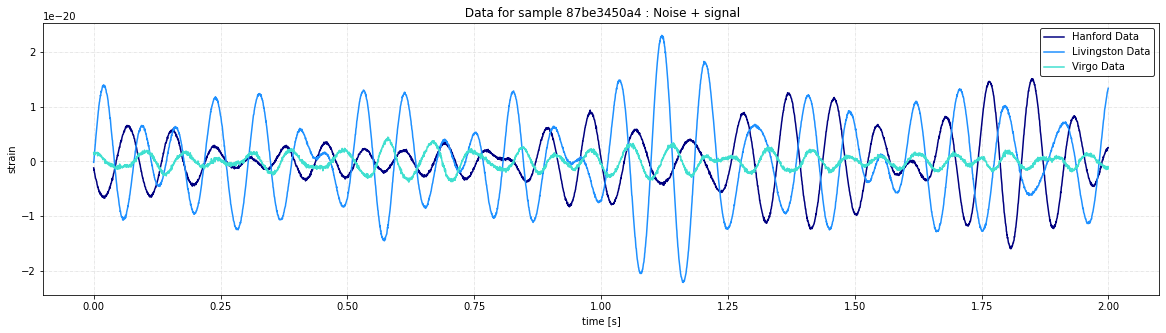

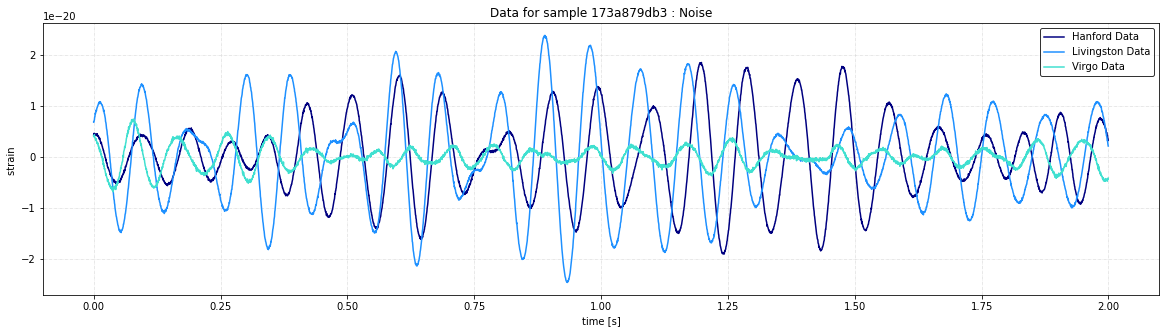

In [30]:
time = np.arange(4096)/2048

for id in sample_ids_1:
    data = get_array(id,True)
    plt.figure(figsize=(20,5))
    plt.plot(time,data[0], color="navy", label="Hanford Data")
    plt.plot(time,data[1], color="dodgerblue", label="Livingston Data")
    plt.plot(time,data[2], color="turquoise", label="Virgo Data")
    plt.xlabel("time [s]")
    plt.ylabel("strain")
    plt.legend(edgecolor='black',loc=1)
    plt.grid(True ,color='lightgrey', which="both",linestyle = '-.',linewidth=0.5)
    plt.title(f" Data for sample {id} : Noise + signal")

for id in sample_ids_0:
    data = get_array(id,True)
    plt.figure(figsize=(20,5))
    plt.plot(time,data[0], color="navy", label="Hanford Data")
    plt.plot(time,data[1], color="dodgerblue", label="Livingston Data")
    plt.plot(time,data[2], color="turquoise", label="Virgo Data")
    plt.xlabel("time [s]")
    plt.ylabel("strain ")
    plt.legend(edgecolor='black',loc=1)
    plt.grid(True ,color='lightgrey', which="both",linestyle = '-.',linewidth=0.5)
    plt.title(f"Data for sample {id} : Noise")


nnAudio CQT1992 spectrogram shape: (69, 193, 1)



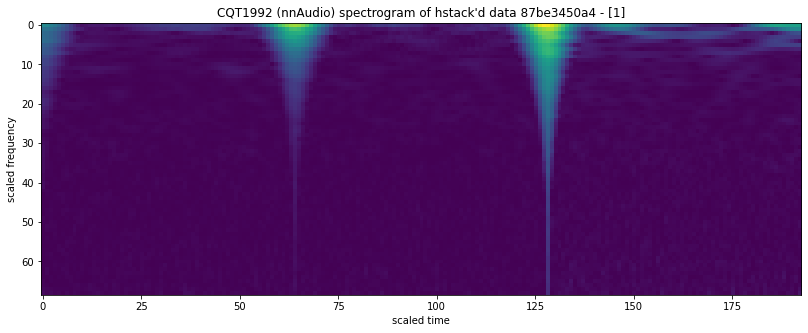

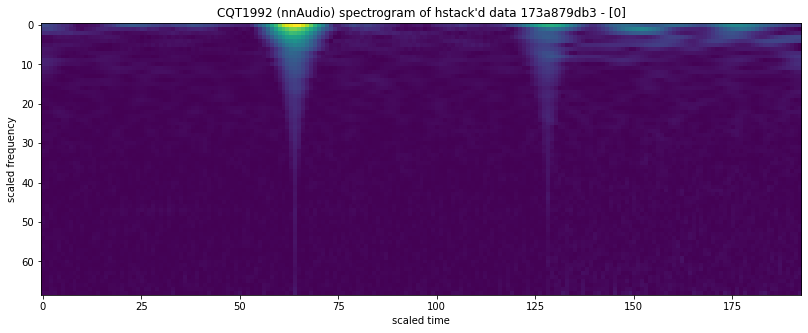

In [31]:
def get_cqt_spectrogram(id, is_train=True):
    cqt = CQT1992v2(sr=SAMPLING_FREQUENCY, hop_length=64, fmin=20, fmax=1024, bins_per_octave=12, norm=1, window='hann', center=True, pad_mode='reflect', trainable=False, output_format='Magnitude', verbose=False)
#     cqt = CQT1992v2(sr=SAMPLING_FREQUENCY, fmin=20, fmax=1024, hop_length=64)
    waveform = np.hstack(get_array(id, is_train))
#     waveform = get_array_n(id, is_train)
    waveform = waveform / np.max(waveform)
    waveform = torch.from_numpy(waveform).float()
    cqt_image = cqt(waveform)
    cqt_image = np.array(cqt_image)
#     cqt_image = np.squeeze(cqt_image, axis=0)
    cqt_image = np.transpose(cqt_image, (1,2,0))
    return cqt_image

def plot_cqt_spectrogram(id, is_train=True):
    image = get_cqt_spectrogram(id, is_train)
    plt.figure(figsize=(20,5))
    plt.imshow(image)
    plt.xlabel("scaled time")
    plt.ylabel("scaled frequency")
    plt.title(f"CQT1992 (nnAudio) spectrogram of hstack'd data {id} - {targets[targets['id'] == id].target.values}")

cqt_image = get_cqt_spectrogram(EXAMPLE_IDENTIFIER_1)
print("")
print(f"nnAudio CQT1992 spectrogram shape: {cqt_image.shape}")
print("")

for id in sample_ids_1:
    plot_cqt_spectrogram(id)
    
for id in sample_ids_0:
    plot_cqt_spectrogram(id)

In [ ]:
def get_scipy_spectrogram(id, is_train=True):
    # Careful using in batch loader, as freq/time axes values are returned also - repeated and complete waste.
    waveform = np.hstack(get_array(id))
    waveform = waveform / np.max(waveform)
    (freq, time, intensity) = signal.spectrogram(waveform, SAMPLING_FREQUENCY, mode="magnitude", scaling="spectrum", window=('kaiser', 14))
    return (freq, time, intensity)

def plot_scipy_spectrogram(id, is_train=True):
    (f, t, i) = get_scipy_spectrogram(id, is_train)
    plt.figure(figsize=(20,5))
    plt.pcolormesh(t, f, i, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0,100)
    plt.title(f"Scipy spectrogram of hstack'd data {id} - {targets[targets['id'] == id].target.values}")
    plt.show()
    
for id in sample_ids_1:
    plot_scipy_spectrogram(id)
    
for id in sample_ids_0:
    plot_scipy_spectrogram(id)

In [ ]:
def get_scipy_fft(id, is_train=True):
    waveform = np.hstack(get_array(id))
#     window = signal.kaiser(SAMPLES_3, 14)
#     window = signal.blackman(SAMPLES_3)
    window = signal.hann(SAMPLES_3)
    return np.abs(fft.rfft(waveform * window))

def plot_scipy_fft(id, is_train=True):
    fast = get_scipy_fft(id)
    xf = fft.rfftfreq(SAMPLES_3, 1 / SAMPLING_FREQUENCY)
    plt.figure(figsize=(20,5))
#     plt.xlim(100, 300)
    plt.yscale("log")
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Relative Amplitude')
    plt.title(f"Scipy rfft of hstack'd data {id} - {targets[targets['id'] == id].target.values}")
    plt.plot(xf, fast)

for id in sample_ids_1:
    plot_scipy_fft(id)
    
for id in sample_ids_0:
    plot_scipy_fft(id)

In [ ]:
def get_welch_periodogram(id, is_train=True):
    f, Pxx_den = signal.welch(np.hstack(get_array(id)), SAMPLING_FREQUENCY, nperseg=1024)
    return f, Pxx_den

def plot_welch_periodogram(id, is_train=True):
    f, Pxx_den = get_welch_periodogram(id)
    plt.figure(figsize=(20,5))
    plt.semilogy(f, Pxx_den)
    # plt.ylim([0.5e-3, 1])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.title(f"Scipy welch periodogram of hstack'd data {id} - {targets[targets['id'] == id].target.values}")
    plt.show()

for id in sample_ids_1:
    plot_welch_periodogram(id)
    
for id in sample_ids_0:
    plot_welch_periodogram(id)

# 2. Model definition

In [ ]:
# Shapes of some of the data considered.

arr = get_array(EXAMPLE_IDENTIFIER_1)
print("\n")
print(f"Shape of array.shape: {arr.shape}")
print(f"Shape of array[0].shape: {arr[0].shape}")
print(f"Shape of np.hstack(array).shape: {np.hstack(arr).shape}")
print(f"Shape of np.vstack(array).shape: {np.vstack(arr).shape}")
print("\n")
(f, t, i) = get_scipy_spectrogram(EXAMPLE_IDENTIFIER_1)
print(f"Shape of scipy spectrogram (get_scipy_spectrogram) time (t of f,t,i): {t.shape}")
print(f"Shape of scipy spectrogram (get_scipy_spectrogram) frequency (f of f,t,i): {f.shape}")
print(f"Shape of scipy spectrogram (get_scipy_spectrogram) intensity (i=(f,t) of f,t,i): {i.shape}")
print(f"Shape of nnAudio CQT1992 spectrogram (get_cqt_spectrogram) (t, f): {get_cqt_spectrogram(EXAMPLE_IDENTIFIER_1).shape}")

In [ ]:
# General Dataset generator, to be extended with specific implementations of fetching sample/batch

class DataSetGenerator(Sequence):
    """Allows batch-loading of the ~50GB training data so we don't exhaust RAM."""

    def get_sample(self, id, is_train):
        """Needs to be implemented by child."""
        pass
    
    def __init__(self, identifiers, y=None, batch_size=256,
        shuffle=True, no_channels=1, no_classes=10, name="Unknown DataSet"):
        """Provided custom parameters for DataGenerator. At minimum, input an array
        of identifiers. If training, input the targets values also."""
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.identifiers = identifiers
        self.y = y
        self.name = name
        if y is not None:
            self.is_training = True
        else:
            self.is_training = False
        self.shape = self.get_sample(self.identifiers[0], self.is_training).shape
        print(f"{self.name} - Shape of each sample: {self.shape}\n")
#         self.on_epoch_end()

    def __len__(self):
        """States number of batches per epoch (rounds up)."""
#         return int(np.ceil(len(self.identifiers) / self.batch_size))
        return math.ceil(len(self.identifiers)/self.batch_size)

    def __getitem__(self, index):
        """Return batch of X (and y if training). Can be overidden in child if model input shape requires."""
        batch_ids = self.identifiers[index * self.batch_size:(index + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]
        
        # batch_X = np.array([get_array(x, self.is_training) for x in batch_ids])
        list_x = np.array([self.get_sample(x, self.is_training) for x in batch_ids])
#         batch_X = batch_X.reshape((batch_X.shape[0], batch_X.shape[1], batch_X.shape[2], 1))
        batch_X = np.stack(list_x)
#         batch_X = batch_X.reshape((batch_X.shape[0], batch_X.shape[1], batch_X.shape[2], 1))
        # batch_X = np.stack(list_x)
        if self.is_training:
            return batch_X, batch_y
        else:
            return batch_X

    def on_epoch_end(self):
        """Shuffle at the end of each epoch."""
        pass
        if self.shuffle and self.is_training:
            ids_y = list(zip(self.identifiers, self.y))
            shuffle(ids_y)
            self.identifiers, self.y = list(zip(*ids_y))

In [ ]:
class TimeSeriesDataSetGenerator(DataSetGenerator):
    """Inherits from DataSetGenerator class, methods to get sample and therefore batch are implemented, simply
    fetching the raw samples of 3x4096 ndarrays."""
    
    def get_sample(self, id, is_train):
        """Return 3x4096 ndarray (time-series data)."""
        return make_array_cyclic(get_array(id, is_train))

In [ ]:
class Cqt1992DataSetGenerator(DataSetGenerator):
    """Inherits from DataSetGenerator class, methods to get sample and therefore batch are implemented, fetches
    CQT1992 spectrogram of the hstack'd arrays."""
    
    def get_sample(self, id, is_train):
        """Return CQT1992 spectrogram."""
        return get_cqt_spectrogram(id, is_train)
    
    def __getitem__(self, index):
        """Return batch of X (and y if training). Can be overidden in child if model input shape requires."""
        batch_ids = self.identifiers[index * self.batch_size:(index + 1) * self.batch_size]
        if self.y is not None:
            batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]

        # batch_X = np.array([get_array(x, self.is_training) for x in batch_ids])
        list_x = np.array([self.get_sample(x, self.is_training) for x in batch_ids])
        # batch_X = batch_X.reshape((batch_X.shape[0], batch_X.shape[1], batch_X.shape[2], 1))
        batch_X = np.stack(list_x)
#         batch_X = batch_X.reshape((batch_X.shape[0], batch_X.shape[1], batch_X.shape[2], 1))

        # batch_X = np.stack(list_x)
        if self.is_training:
            return batch_X, batch_y
        else:
            return batch_X

In [ ]:
def get_basic_cnn_model(shape):
    """Returns compiled model (callbacks, history, fitting etc not done here)."""
#     # detect and init the TPU
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

#     # instantiate a distribution strategy
#     tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

#     # instantiating the model in the strategy scope creates the model on the TPU
#     with tpu_strategy.scope():
    model = Sequential([
        layers.InputLayer(input_shape=(shape[0], shape[1], 1), name="Input"),
        layers.Conv2D(3, (2,1024), strides=(1,512), padding='same', name="Conv2D_1"),
        layers.MaxPooling2D(pool_size=(2,4), strides=(1, 2), padding='valid', name="MaxPooling_1"),
#         layers.Conv2D(64, 3, activation='relu', padding='same', name="Conv2D_2"),
#         layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='valid', name="MaxPooling_2"),
#         layers.GlobalAveragePooling2D(name="GlobalAveragePooling_1"),
        layers.Flatten(),
        layers.Dense(32, activation='relu', name="Dense_1"),
        layers.Dense(1, activation='sigmoid', name="Dense_2")
    ])
    
    # Print summary of model layers.
    model.summary()
    # Draw diagram of model
    # utils.plot_model(model, to_file="model.png", show_shapes=True)
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=[metrics.AUC()])
    return model

In [ ]:
def get_cqt1992_model(shape):
    """Returns compiled model (callbacks, history, fitting etc not done here)."""
    # Build model layers.
    model = Sequential([
        layers.InputLayer(input_shape=(shape[0],shape[1],1)),
        layers.Conv2D(3,3,activation='relu',padding='same'),
#         EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'),
        EfficientNetB1(include_top=False,input_shape=(),weights='imagenet'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(32,activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Print summary of model layers.
    model.summary()
    
    # Draw diagram of model
    # utils.plot_model(model, to_file="model.png", show_shapes=True)
    
    # Compile with specific optimizer / loss / metric.
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=[metrics.AUC()])
    return model

In [ ]:
def get_model_template(shape):
    """Returns compiled model (callbacks, history, fitting etc not done here)."""
    # Build model layers.
    model = Sequential([
        layers.InputLayer(input_shape=(shape[0], shape[1], 1), name="Input"),
        layers.Conv2D(3, (2,1024), strides=(1,512), padding='same', name="Conv2D_1"),
        # layers.BatchNormalization(),
        # layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2,4), strides=(1, 2), padding='valid', name="MaxPooling_1"),
        layers.Flatten(),
        layers.Dense(32, activation='relu', name="Dense_1"),
        layers.Dense(1, activation='sigmoid', name="Dense_2")
        # layers.Dense(1, activation='softmax', name="Dense_1")
    ])
    
    # Print summary of model layers.
    model.summary()
    
    # Draw diagram of model
    # utils.plot_model(model, to_file="model.png", show_shapes=True)
    
    # Compile with specific optimizer / loss / metric.
#     model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[metrics.AUC()])
    return model

In [ ]:
# Set up DataSetGenerator and get model

targets = pd.read_csv(f"{TOP_INPUT_DIRECTORY}/training_labels.csv")
sample_submission = pd.read_csv(f"{TOP_INPUT_DIRECTORY}/sample_submission.csv")

if USE_TRAIN_SUBSET:
    targets = targets.sample(SUBSET_SIZE)
    
if USE_TEST_SUBSET:
    sample_submission = sample_submission.sample(SUBSET_SIZE)

test_identifiers = sample_submission["id"].values
identifiers = targets["id"].values
y = targets["target"].values

# print(identifiers[:5])
# print(y[:5])
# print(test_identifiers[:5])

train_x, valid_x, train_y, valid_y = train_test_split(identifiers, y, train_size=TRAIN_TEST_SPLIT, random_state=42, stratify=y)



# train_dataset = TimeSeriesDataSetGenerator(train_x, train_y, batch_size=BATCH_SIZE, name="Training")
# valid_dataset = TimeSeriesDataSetGenerator(valid_x, valid_y, batch_size=BATCH_SIZE, name="Validation")
# test_dataset = TimeSeriesDataSetGenerator(test_identifiers, batch_size=BATCH_SIZE, name="Test")

train_dataset = Cqt1992DataSetGenerator(train_x, train_y, batch_size=BATCH_SIZE, name="Training")
valid_dataset = Cqt1992DataSetGenerator(valid_x, valid_y, batch_size=BATCH_SIZE, name="Validation")
test_dataset = Cqt1992DataSetGenerator(test_identifiers, batch_size=BATCH_SIZE, name="Test")

assert train_dataset.shape == valid_dataset.shape == test_dataset.shape

# Get shape from chosen DataSet, and input to model.
sample_shape = train_dataset.shape
# print(sample_shape)
print("\n\n\n")
model = get_cqt1992_model(sample_shape)



# Add extras like callbacks to model, and fit.

# Model callbacks/fitting etc specifics
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=0.001
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=1),
]

In [ ]:
if PERFORM_FITTING:
    # Fit model (obtaining history for later plotting).
#     history = model.fit(
    model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=EPOCHS,
    #     callbacks=callbacks,
        # validation_split=0.2,
        verbose=1,
    )